# Quora question pairs: data preparation

## Import packages

In [1]:
from __future__ import print_function

import numpy as np
import csv, json
from zipfile import ZipFile
from os.path import expanduser, exists

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.data_utils import get_file

Using TensorFlow backend.


## Initialize global variables

In [2]:
KERAS_DATASETS_DIR = expanduser('~/.keras/datasets/')
QUESTION_PAIRS_FILE_URL = 'http://qim.ec.quoracdn.net/quora_duplicate_questions.tsv'
QUESTION_PAIRS_FILE = 'quora_duplicate_questions.tsv'
GLOVE_ZIP_FILE_URL = 'http://nlp.stanford.edu/data/glove.840B.300d.zip'
GLOVE_ZIP_FILE = 'glove.840B.300d.zip'
GLOVE_FILE = 'glove.840B.300d.txt'
Q1_TRAINING_DATA_FILE = 'q1_train.npy'
Q2_TRAINING_DATA_FILE = 'q2_train.npy'
LABEL_TRAINING_DATA_FILE = 'label_train.npy'
WORD_EMBEDDING_MATRIX_FILE = 'word_embedding_matrix.npy'
NB_WORDS_DATA_FILE = 'nb_words.json'
MAX_NB_WORDS = 200000
MAX_SEQUENCE_LENGTH = 25
EMBEDDING_DIM = 300

## Download and extract questions pairs data

In [3]:
if not exists(KERAS_DATASETS_DIR + QUESTION_PAIRS_FILE):
    get_file(QUESTION_PAIRS_FILE, QUESTION_PAIRS_FILE_URL)

print("Processing", QUESTION_PAIRS_FILE)

question1 = []
question2 = []
is_duplicate = []
with open(KERAS_DATASETS_DIR + QUESTION_PAIRS_FILE, encoding='utf-8') as csvfile:
    reader = csv.DictReader(csvfile, delimiter='\t')
    for row in reader:
        question1.append(row['question1'])
        question2.append(row['question2'])
        is_duplicate.append(row['is_duplicate'])

print('Question pairs: %d' % len(question1))

58179584/58176133 [==============================] - 0s 0us/step
Processing quora_duplicate_questions.tsv
Question pairs: 404290


## Build tokenized word index

In [4]:
questions = question1 + question2
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(questions)
question1_word_sequences = tokenizer.texts_to_sequences(question1)
question2_word_sequences = tokenizer.texts_to_sequences(question2)
word_index = tokenizer.word_index

print("Words in index: %d" % len(word_index))

Words in index: 95596


## Download and process GloVe embeddings

In [5]:
if not exists(KERAS_DATASETS_DIR + GLOVE_ZIP_FILE):
    zipfile = ZipFile(get_file(GLOVE_ZIP_FILE, GLOVE_ZIP_FILE_URL))
    zipfile.extract(GLOVE_FILE, path=KERAS_DATASETS_DIR)
    
print("Processing", GLOVE_FILE)

embeddings_index = {}
with open(KERAS_DATASETS_DIR + GLOVE_FILE, encoding='utf-8') as f:
    for line in f:
        values = line.split(' ')
        word = values[0]
        embedding = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = embedding

print('Word embeddings: %d' % len(embeddings_index))

1059217408/2176768927 [=============>................] - ETA: 59s

2176770048/2176768927 [==============================] - 115s 0us/step
Processing glove.840B.300d.txt
Word embeddings: 2196016


## Prepare word embedding matrix

In [6]:
nb_words = min(MAX_NB_WORDS, len(word_index))
word_embedding_matrix = np.zeros((nb_words + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    if i > MAX_NB_WORDS:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        word_embedding_matrix[i] = embedding_vector

print('Null word embeddings: %d' % np.sum(np.sum(word_embedding_matrix, axis=1) == 0))

Null word embeddings: 29276


## Prepare training data tensors

In [7]:
q1_data = pad_sequences(question1_word_sequences, maxlen=MAX_SEQUENCE_LENGTH)
q2_data = pad_sequences(question2_word_sequences, maxlen=MAX_SEQUENCE_LENGTH)
labels = np.array(is_duplicate, dtype=int)
print('Shape of question1 data tensor:', q1_data.shape)
print('Shape of question2 data tensor:', q2_data.shape)
print('Shape of label tensor:', labels.shape)

Shape of question1 data tensor: (404290, 25)
Shape of question2 data tensor: (404290, 25)
Shape of label tensor: (404290,)


## Persist training and configuration data to files

In [8]:
np.save(open(Q1_TRAINING_DATA_FILE, 'wb'), q1_data)
np.save(open(Q2_TRAINING_DATA_FILE, 'wb'), q2_data)
np.save(open(LABEL_TRAINING_DATA_FILE, 'wb'), labels)
np.save(open(WORD_EMBEDDING_MATRIX_FILE, 'wb'), word_embedding_matrix)
with open(NB_WORDS_DATA_FILE, 'w') as f:
    json.dump({'nb_words': nb_words}, f)

In [11]:
!ls -lh

total 300M
drwxr-xr-x 3 root root 4.0K Jul  2 16:56 datalab
-rw-r--r-- 1 root root 3.1M Jul  4 09:44 label_train.npy
-rw-r--r-- 1 root root   19 Jul  4 09:44 nb_words.json
-rw-r--r-- 1 root root  39M Jul  4 09:44 q1_train.npy
-rw-r--r-- 1 root root  39M Jul  4 09:44 q2_train.npy
-rw-r--r-- 1 root root 219M Jul  4 09:44 word_embedding_matrix.npy


In [13]:
%matplotlib inline
from __future__ import print_function
import numpy as np
import pandas as pd
import datetime, time, json
from keras.models import Model
from keras.layers import Input, TimeDistributed, Dense, Lambda, concatenate, Dropout, BatchNormalization
from keras.layers.embeddings import Embedding
from keras.regularizers import l2
from keras.callbacks import Callback, ModelCheckpoint
from keras import backend as K
from sklearn.model_selection import train_test_split

## Initialize global variables

In [14]:
Q1_TRAINING_DATA_FILE = 'q1_train.npy'
Q2_TRAINING_DATA_FILE = 'q2_train.npy'
LABEL_TRAINING_DATA_FILE = 'label_train.npy'
WORD_EMBEDDING_MATRIX_FILE = 'word_embedding_matrix.npy'
NB_WORDS_DATA_FILE = 'nb_words.json'
MODEL_WEIGHTS_FILE = 'question_pairs_weights.h5'
MAX_SEQUENCE_LENGTH = 25
EMBEDDING_DIM = 300
VALIDATION_SPLIT = 0.1
TEST_SPLIT = 0.1
RNG_SEED = 13371447
NB_EPOCHS = 25
DROPOUT = 0.1
BATCH_SIZE = 32

## Load the dataset, embedding matrix and word count

In [15]:
q1_data = np.load(open(Q1_TRAINING_DATA_FILE, 'rb'))
q2_data = np.load(open(Q2_TRAINING_DATA_FILE, 'rb'))
labels = np.load(open(LABEL_TRAINING_DATA_FILE, 'rb'))
word_embedding_matrix = np.load(open(WORD_EMBEDDING_MATRIX_FILE, 'rb'))
with open(NB_WORDS_DATA_FILE, 'r') as f:
    nb_words = json.load(f)['nb_words']

## Partition the dataset into train and test sets

In [16]:
X = np.stack((q1_data, q2_data), axis=1)
y = labels
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SPLIT, random_state=RNG_SEED)
Q1_train = X_train[:,0]
Q2_train = X_train[:,1]
Q1_test = X_test[:,0]
Q2_test = X_test[:,1]

## Define the model

In [23]:
question1 = Input(shape=(MAX_SEQUENCE_LENGTH,))
question2 = Input(shape=(MAX_SEQUENCE_LENGTH,))

q1 = Embedding(nb_words + 1, 
                 EMBEDDING_DIM, 
                 weights=[word_embedding_matrix], 
                 input_length=MAX_SEQUENCE_LENGTH, 
                 trainable=False)(question1)
q1 = TimeDistributed(Dense(EMBEDDING_DIM, activation='relu'))(q1)
q1 = Lambda(lambda x: K.max(x, axis=1), output_shape=(EMBEDDING_DIM, ))(q1)

q2 = Embedding(nb_words + 1, 
                 EMBEDDING_DIM, 
                 weights=[word_embedding_matrix], 
                 input_length=MAX_SEQUENCE_LENGTH, 
                 trainable=False)(question2)
q2 = TimeDistributed(Dense(EMBEDDING_DIM, activation='relu'))(q2)
q2 = Lambda(lambda x: K.max(x, axis=1), output_shape=(EMBEDDING_DIM, ))(q2)

merged = concatenate([q1,q2])
#merged = Dense(200, activation='relu')(merged)
#merged = Dropout(DROPOUT)(merged)
#merged = BatchNormalization()(merged)
#merged = Dense(200, activation='relu')(merged)
#merged = Dropout(DROPOUT)(merged)
#merged = BatchNormalization()(merged)
#merged = Dense(200, activation='relu')(merged)
#merged = Dropout(DROPOUT)(merged)
#merged = BatchNormalization()(merged)
merged = Dense(200, activation='relu')(merged)
merged = Dropout(DROPOUT)(merged)
#merged = BatchNormalization()(merged)

is_duplicate = Dense(1, activation='sigmoid')(merged)

model = Model(inputs=[question1,question2], outputs=is_duplicate)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [24]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 25)           0                                            
__________________________________________________________________________________________________
input_8 (InputLayer)            (None, 25)           0                                            
__________________________________________________________________________________________________
embedding_7 (Embedding)         (None, 25, 300)      28679100    input_7[0][0]                    
__________________________________________________________________________________________________
embedding_8 (Embedding)         (None, 25, 300)      28679100    input_8[0][0]                    
__________________________________________________________________________________________________
time_distr

## Train the model, checkpointing weights with best validation accuracy

In [0]:
print("Starting training at", datetime.datetime.now())
t0 = time.time()
callbacks = [ModelCheckpoint(MODEL_WEIGHTS_FILE, monitor='val_acc', save_best_only=True)]
S= int(len(Q1_train)/2)
print (f'training on a subset of size {S}')
history = model.fit([Q1_train[:S], Q2_train[:S]],
                    y_train[:S],
                    epochs=NB_EPOCHS,
                    validation_split=VALIDATION_SPLIT,
                    verbose=2,
                    batch_size=BATCH_SIZE,
                    callbacks=callbacks)
t1 = time.time()
print("Training ended at", datetime.datetime.now())
print("Minutes elapsed: %f" % ((t1 - t0) / 60.))

Starting training at 2018-07-04 10:02:19.251590
training on a subset of size 181930
Train on 163737 samples, validate on 18193 samples
Epoch 1/25
 - 41s - loss: 0.4681 - acc: 0.7742 - val_loss: 0.4700 - val_acc: 0.7685
Epoch 2/25
 - 41s - loss: 0.4251 - acc: 0.7966 - val_loss: 0.4642 - val_acc: 0.7760
Epoch 3/25


## Plot training and validation accuracy

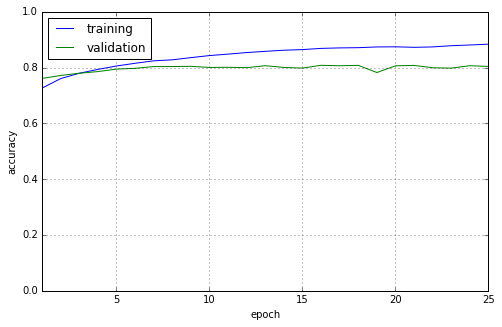

In [0]:
acc = pd.DataFrame({'epoch': [ i + 1 for i in history.epoch ],
                    'training': history.history['acc'],
                    'validation': history.history['val_acc']})
ax = acc.iloc[:,:].plot(x='epoch', figsize={5,8}, grid=True)
ax.set_ylabel("accuracy")
ax.set_ylim([0.0,1.0]);

## Print best validation accuracy and epoch

In [0]:
max_val_acc, idx = max((val, idx) for (idx, val) in enumerate(history.history['val_acc']))
print('Maximum accuracy at epoch', '{:d}'.format(idx+1), '=', '{:.4f}'.format(max_val_acc))

Maximum accuracy at epoch 16 = 0.8083


## Evaluate the model with best validation accuracy on the test partition

In [0]:
model.load_weights(MODEL_WEIGHTS_FILE)
loss, accuracy = model.evaluate([Q1_test, Q2_test], y_test, verbose=0)
print('loss = {0:.4f}, accuracy = {1:.4f}'.format(loss, accuracy))

loss = 0.4102, accuracy = 0.8110
